### Girvan-Newman Partitioning

The purpose of this homework is to teach you 
- about what the Girvan-Newman partitioning algorithm does
- how to use the modularity metric to find a good partition
- practice using dendrograms to understand partioning

The tutorial will use the karate class graph to demonstrate different steps in the process, and the homework will ask you to apply these steps to a few different graphs. The homework will also ask you to interpret what you are seeing for the different graphs.

---

#### Utilities

As usual, we'll start by defining some utilities for showing graphs and partitions.

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
from typing import Tuple, Hashable, Union, Literal
from numpy import linalg as linalg
from matplotlib.axes import Axes

####################################
## Create datatype that specifies ##
## the style of the graph display ##
####################################
PlotType = Literal[
    "GRAPHVIZ",
    "CIRCULAR",
    "SPRING"
]

#################################
## Show graph with node labels ##
## in a chosen set of axes     ##
#################################
def show_graph(G: nx.Graph,
               title: str = "",
               labels: Union[dict[int, str], None] = None,
               axes: Union[None, Axes] = None,
               node_color: Union[None, list[str]] = None,
               plot_style: PlotType = "GRAPHVIZ"
               ) -> dict[Hashable, Tuple[float, float]]:
    if labels is None:
        labels = {node: str(node) for node in G.nodes()}
    if axes is None:
        plt.figure(figsize=(4,4))
        axes: Axes = plt.gca()
    if node_color is None:
        node_color = ['y' for _ in G.nodes]
    node_positions: dict[Hashable, tuple[float, float]] = dict()
    if plot_style == "GRAPHVIZ":
        node_positions = nx.nx_pydot.graphviz_layout(G,prog='neato')
    elif plot_style == "SPRING":
        node_positions = nx.spring_layout(G)
    else:
        node_positions = nx.circular_layout(G)

    nx.draw(G, 
        node_positions, 
        node_color = node_color, 
        with_labels = True, 
        labels = labels,
        node_size = 300,
        ax=axes, 
        alpha=0.8)
    
    axes.set_title(title)
    axes.set_aspect('equal')
    # Add some padding around the nodes
    x, y = zip(*node_positions.values())
    xmin = float(np.min(x))
    xmax = float(np.max(x))
    ymin = float(np.min(y))
    ymax = float(np.max(y))
    axes.set_xlim(xmin - 0.2*(xmax-xmin), xmax +0.2*(xmax-xmin))
    axes.set_ylim(ymin - 0.2*(ymax-ymin), ymax +0.2*(ymax-ymin))
    
    # Return the node positions in case I want to use them again
    return node_positions


Show the karate class network

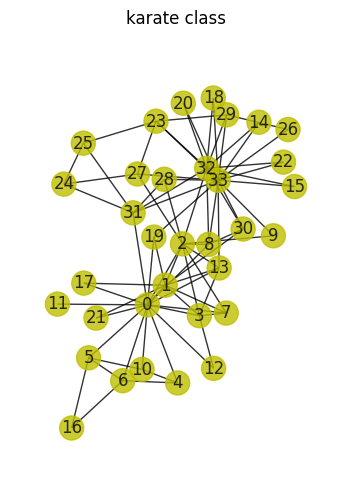

In [25]:
karate_class: nx.Graph = nx.karate_club_graph()
_ = plt.figure(figsize=(6,6))
axes = plt.gca()
_ = show_graph(karate_class, title = "karate class", axes = axes)

---

#### Girvan-Newman partitioning

The Girvan-Newman partitioning algorithm greedily removes the edge with highest _edge betweenness_. The algorithm stops when a partition with maximum modularity is found (with reasonable confidence). 

We'll use the `nx.girvan_newman` to find all possible communities which can be obtained by greedily removing the edge with highes edge betweenness. See [girvan_newman](!https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html).

In [26]:
from typing import Iterator, Tuple
partitions: Iterator = nx.community.girvan_newman(karate_class)
partition_list: list[Tuple[set, ]] = list(partitions)
print(partition_list)
for communities in partition_list:
    print(tuple(sorted(c) for c in communities))

[({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}, {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}), ({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}, {32, 33, 2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}, {9}), ({0, 1, 3, 7, 11, 12, 13, 17, 19, 21}, {32, 33, 2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}, {4, 5, 6, 10, 16}, {9}), ({0, 1, 3, 7, 11, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 26, 29, 30}, {9}), ({0, 1, 3, 7, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 26, 29, 30}, {9}, {11}), ({0, 1, 3, 7, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 29, 30}, {9}, {11}, {26}), ({0, 1, 3, 7, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 29, 30}, {9}, {11}, {12}, {26}), ({0, 1, 3, 7, 13, 17, 19, 21}, {2

Each line above represents a different possible partitioning of the vertices into groups. The first line partitions vertices into two groups, the second line into three groups, and the last line into one-group-per vertex.

---

Let's take a peak at the first partition. We'll display the groups by separating vertices into different colors, with all the vertices in a single group assigned the same color. 

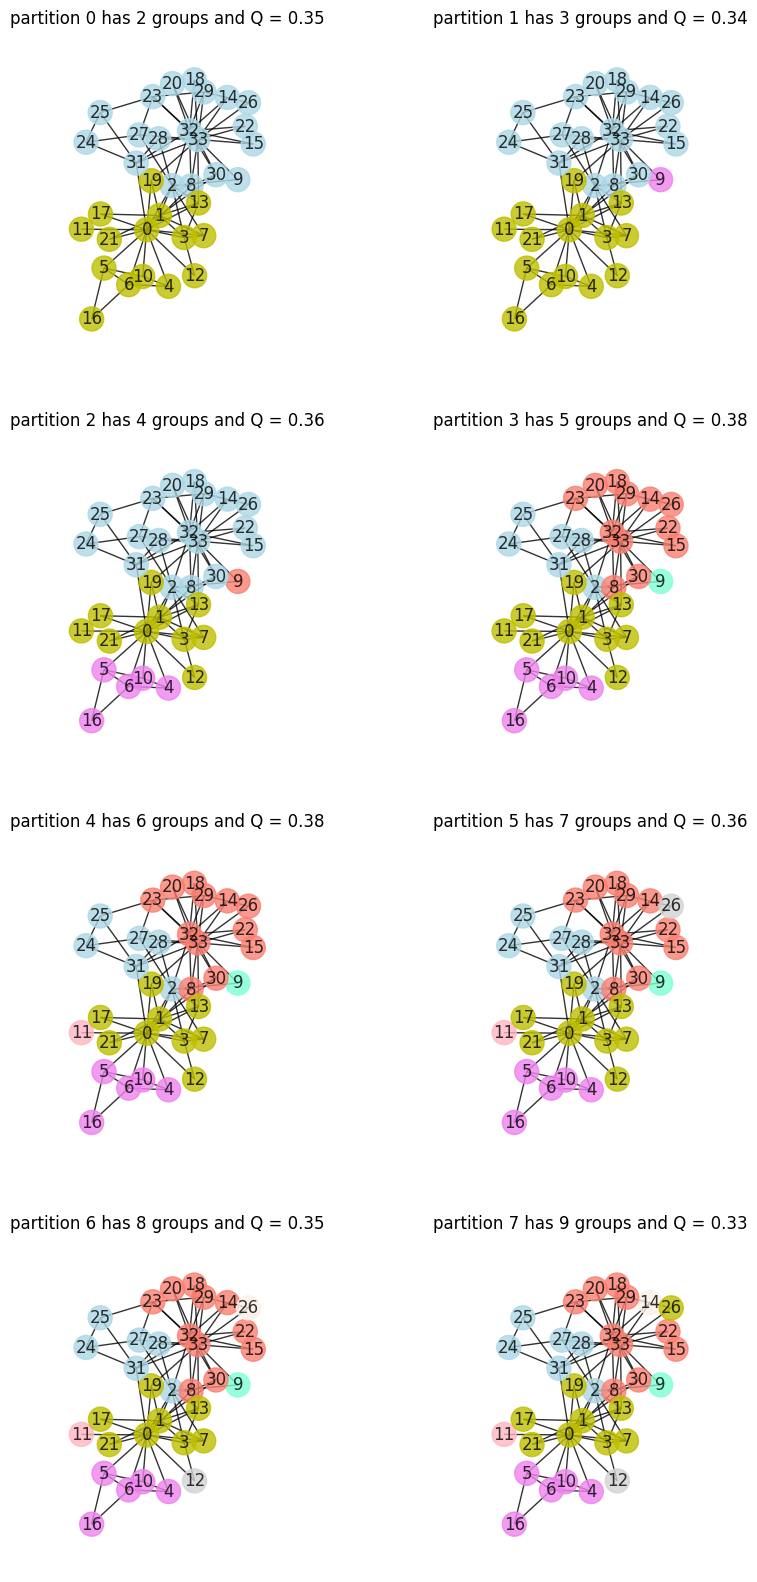

In [41]:
colors: list[str] = ['y', 'lightblue', 'violet', 'salmon', 
                         'aquamarine', 'lightpink', 'lightgray', 'linen']

_, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
for i in range(8): # Iterate through the first four groups
    node_group_dict: dict[int, int] = {node: 0 for node in sorted(karate_class.nodes())}
    for group_num in range(len(partition_list[i])):
        for node in partition_list[i][group_num]:
            node_group_dict[node] = group_num
    
    node_colors = [colors[node_group_dict[node]%len(colors)] for node in karate_class.nodes()]
    title: str = f"partition {i} "
    title = title + f"has {len(partition_list[i])} groups "
    title = title + f"and Q = {np.round(nx.community.modularity(karate_class, partition_list[i]),2)}"
    _ = show_graph(karate_class, 
                   node_color=node_colors, 
                   axes=axes[int(np.floor(i/2)), i%2],
                   title = title)